In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("StudyEventTimeSeries.csv")

In [3]:
import numpy as np

In [4]:
codelist = list(set(df.as_matrix().flatten()))
codelist.remove(np.nan)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [5]:
featureOnly= list(filter(lambda x: x.isupper(),codelist))
themeOnly= list(filter(lambda x: x.islower(),codelist))

In [6]:
# df["t"]=df.index

In [7]:
df = df.stack().reset_index()

In [8]:
df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

In [9]:
import altair as alt

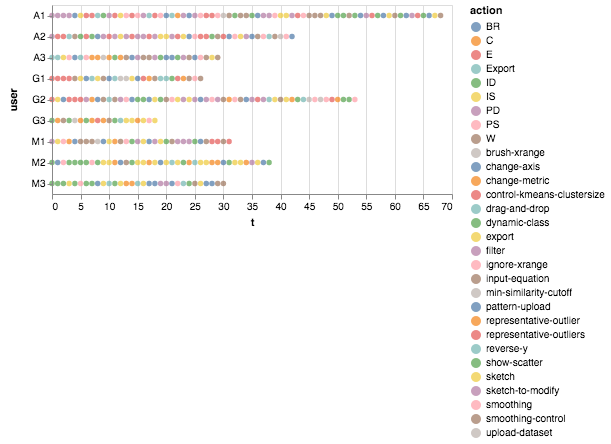

In [10]:
alt.Chart(df).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

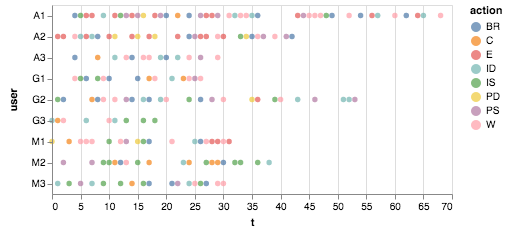

In [11]:
df_action = df[df.action.isin(featureOnly)]
alt.Chart(df_action).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

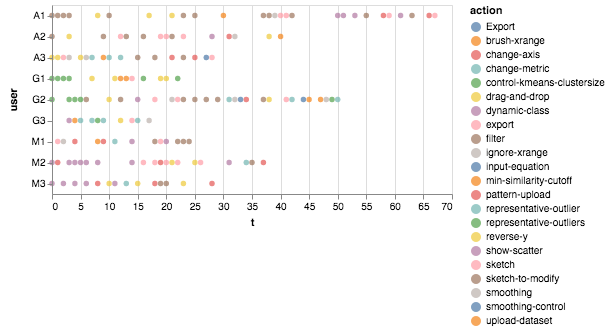

In [12]:
df_feature = df[~df.action.isin(featureOnly)]
alt.Chart(df_feature).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)